In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import sys

from datetime import datetime, timedelta

In [4]:
def get_info_from_filename(fili):
    '''
    Purpose: string splitting to extract some information from the input file name.

    Input: File name of CSV file with all variations in it (string)
        example: 'Rhine_ESI14_dwindow21_jump-2.0.csv'
    Output: (list of strings, len=4)
        basin: River basin (example: Rhine)
        indexscale: index + scale (example: ESI14)
        window: amount of days over which we take the jump (example: 21)
        jump: jump in index (example: 2.0)
    '''
    basin, indexscale = fili.split('_')[0:-2]
    window = int(fili.split('_')[-2][-2::])
    jump = int(fili.split('_')[-1].split('.')[0][-2::])/10
    return basin, indexscale, window, jump



def check_leap_year(year):
    leap_year = False
    if((year % 400 == 0) or  (year % 100 != 0) and  (year % 4 == 0)):  
        leap_year = True
    return leap_year


def define_ts_length(year,month,day,window,extra_len):

    # make the right type
    window = int(window)
    extra_len = int(extra_len)
    
    start_FD_time = datetime(year,month,day)

    # when do we want the composite timeseries to start and end:
    start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len))
    end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len))

    # however, if there is a leap day in this period, we need to add an extra day to the time series before or after  
    if check_leap_year(year):
        leap_day = datetime(year,2,29)
        
        # is the leap day between the start of the timeseries and the start of the event: add a day BEFORE
        if start_ts_time <= leap_day <= start_FD_time:
            start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len+1))
        # is the leap day between the the start of the event and the end of the timeseries: add a day AFTER
        elif start_FD_time <= leap_day <= end_ts_time:
            end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))

    return start_ts_time, end_ts_time


def make_composites(df, var, window, extra_len, indexscale, basin, anom=False):
    '''
    
    '''
    # make the right type
    window = int(window)
    extra_len = int(extra_len)

    # initialise timeseries
    timeseries = []

    for index, row in df.iterrows():

        # step 1: gather what info we have about the start date of the FD events:
        year=row["year"]
        month = row["month"]
        day = row["day"]

        # step 2: compute the dates we want the composite timeseries to start and end
        start_ts_time, end_ts_time = define_ts_length(year, month, day, window, extra_len)

        # step 3: open the data file and extract the timeseries we want for the event we want
        indexscales = []
        # even op een rijtje zetten elke we hebben
        for scale in (7,14,21,28):
            for index in ['SPI','SPEI','ESI','SMI']:
                indexscale = f'{index}-{scale}'
                indexscales.append(indexscale)
        if var in indexscales:
            diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
            fili = f'{var}_{basin}.nc'
            ds=xr.open_dataset(diri+fili)
        elif var in ['pr','et','pet','tas','rsds','mrsos']:
            diri = '/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
            if anom: 
                filis = f'{var}_{basin}_????_anom.nc'
                ds=xr.open_mfdataset(diri+filis)
            else: 
                filis = f'{var}_{basin}_????.nc'
                ds=xr.open_mfdataset(diri+filis)

        # da = ds['ESI14'].sel(time=slice(start_ts_time,end_ts_time))
        da = ds[var].sel(time=slice(start_ts_time,end_ts_time))
        dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit='D')

        try: 
            da = da.assign_coords(time = dt.days)
            da = da.assign_coords(event = index)
            timeseries.append(da)
        except ValueError:
            pass


    ds_combined = xr.concat(timeseries, dim='event')
    return ds_combined

def save_as_netcdf(ds, var, basin, index, scale, window, jump, diro, anom=False):
    '''
    Purpose: Save ds of composite data to netcdf in right location for var == varname
    mind encoding, otherwise it will throw error when opening with nvciew 
         --> (ncview: netcdf_dim_value: unknown data type (10) for dimension time) - this is an integer (days)
         --> (ncview: ncview: netcdf_dim_value: unknown data type (12) for dimension ensemble_member_year) - this is a string of 9 characters (h010_2000 etc.)
    
    Input: ds and strings to compose the output filename and location

    Out: netcdf file saved in f'{diro}/{filo}' 
    '''
    jumpout = int(abs(jump)*10)

    if anom: 
        filo = f'{var}_anom_{basin}_{index}-{scale}_w{window}_j{jumpout}.nc'
    else: 
        filo = f'{var}_{basin}_{index}-{scale}_w{window}_j{jumpout}.nc'

    ds.to_netcdf(diro+filo, unlimited_dims='event', encoding={'time': {'dtype': 'i4'}, 'event': {'dtype': 'i4'}})

In [3]:
def make_composites_oud(df, window, extra_len, indexscale, basin):
    '''
    
    '''
    # make the right type
    window = int(window)
    extra_len = int(extra_len)

    # initialise timeseries
    timeseries = []

    for index, row in df.iterrows():

        # step 1: gather what info we have about the start date of the FD events:
        year=row["year"]
        month = row["month"]
        day = row["day"]

        # step 2: compute the dates we want the composite timeseries to start and end
        start_ts_time, end_ts_time = define_ts_length(year, month, day, window, extra_len)

        # step 3: open the data file and extract the timeseries we want for the event we want
        diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
        fili = f'{indexscale}_{basin}.nc'
        ds=xr.open_dataset(diri+fili)

        # da = ds['ESI14'].sel(time=slice(start_ts_time,end_ts_time))
        da = ds[indexscale].sel(time=slice(start_ts_time,end_ts_time))
        dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit='D')

        try: 
            da = da.assign_coords(time = dt.days)
            da = da.assign_coords(event = index)
            timeseries.append(da)
        except ValueError:
            pass


    ds_combined = xr.concat(timeseries, dim='event')
    return ds_combined

In [138]:
var = 'ESI-14'
basin = 'Rhine'
indexscale = var
index = 'ESI'
scale = 14
anom = False
window = 21
jumpout = 20
extra_len = 65
diri_csv = '/perm/nklm/Px_flashdroughts/ERA5_FD_events/'
fili_csv = f'{basin}_{index}-{scale}_w{window}_j{jumpout}.csv'

# diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
# fili = f'{indexscale}_{basin}.nc'
df = pd.read_csv(diri_csv+fili_csv,index_col=0)

ds_oud = make_composites_oud(df, window, extra_len, indexscale, basin)
ds_new = make_composites(df, var, window, extra_len, indexscale, basin, anom=False)

In [139]:
ds_oud

<xarray.DataArray 'ESI-14' (event: 104, time: 151)>
array([[ 0.5348465 ,  0.57161244,  0.685338  , ...,  0.05046891,
         0.13609785,  0.19833888],
       [-0.1219602 , -0.0274114 , -0.09697904, ..., -1.35053423,
        -1.45287147, -1.64085587],
       [-0.38827383, -0.38995989, -0.35457788, ...,  0.21959454,
         0.20251233, -0.26498203],
       ...,
       [-1.36982944, -1.32132177, -1.27865577, ..., -0.42071423,
        -0.258934  , -0.28269661],
       [-0.09744839, -0.15756422, -0.16427002, ...,  0.37484252,
         0.52191306,  0.64265957],
       [ 0.69370222,  0.50249912,  0.41728101, ..., -1.1516936 ,
        -1.20979006, -1.33007553]])
Coordinates:
  * time     (time) int64 -65 -64 -63 -62 -61 -60 -59 ... 79 80 81 82 83 84 85
  * event    (event) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104
Attributes:
    units:          -
    standard_name:  ESI-14_14d
    long_name:      ESI-14 standardized index of es (evaporative stress (ET -...

In [140]:
ds_new

<xarray.DataArray 'ESI-14' (event: 104, time: 151)>
array([[ 0.5348465 ,  0.57161244,  0.685338  , ...,  0.05046891,
         0.13609785,  0.19833888],
       [-0.1219602 , -0.0274114 , -0.09697904, ..., -1.35053423,
        -1.45287147, -1.64085587],
       [-0.38827383, -0.38995989, -0.35457788, ...,  0.21959454,
         0.20251233, -0.26498203],
       ...,
       [-1.36982944, -1.32132177, -1.27865577, ..., -0.42071423,
        -0.258934  , -0.28269661],
       [-0.09744839, -0.15756422, -0.16427002, ...,  0.37484252,
         0.52191306,  0.64265957],
       [ 0.69370222,  0.50249912,  0.41728101, ..., -1.1516936 ,
        -1.20979006, -1.33007553]])
Coordinates:
  * time     (time) int64 -65 -64 -63 -62 -61 -60 -59 ... 79 80 81 82 83 84 85
  * event    (event) <U3 'SMI' 'SMI' 'SMI' 'SMI' ... 'SMI' 'SMI' 'SMI' 'SMI'
Attributes:
    units:          -
    standard_name:  ESI-14_14d
    long_name:      ESI-14 standardized index of es (evaporative stress (ET -...

In [134]:
var = 'ESI-14'
basin = 'Rhine'
indexscales = []
anom = False

for scale in (7,14,21,28):
    for index in ['SPI','SPEI','ESI','SMI']:
        indexscale = f'{index}-{scale}'
        indexscales.append(indexscale)
if var in indexscales:
    print('var in indexscales')
    diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
    fili = f'{indexscale}_{basin}.nc'
    ds=xr.open_dataset(diri+fili)
elif var in ['pr','et','pet','tas','rsds','mrsos']:
    diri = '/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
    if anom: 
        filis = f'{var}_{basin}_????_anom.nc'
        ds=xr.open_mfdataset(diri+filis)
    else: 
        filis = f'{var}_{basin}_????.nc'
        ds=xr.open_mfdataset(diri+filis)

var in indexscales


In [135]:
ds

<xarray.Dataset>
Dimensions:  (time: 26645)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T11:00:00 ... 2022-12-31T11:00:00
Data variables:
    SMI-28   (time) float64 ...

In [131]:
indexscales = []
for scale in (7,14,21,28):
    for index in ['SPI','SPEI','ESI','SMI']:
        indexscale = f'{index}-{scale}'
        indexscales.append(indexscale)



In [133]:
indexscales.T

AttributeError: 'list' object has no attribute 'T'

In [ ]:
diri = '/perm/nklm/Px_flashdroughts/ERA5_FD_events/'
diro = '/scratch/nklm/Px_flashdroughts/composites/'
basin = 'Rhine'
extra_len = int(65)

vars = ['SPI-14', 'tas']


#for index in ['SPI','SPEI','ESI','SMI']:
for index in ['ESI',]:
    # for scale in [7,14,21,28]:
    for scale in [14,21]:
        # for window in [7,14,21,28]:
        for window in [21,28]:
            for jump in np.arange(-1.5,-2.5,-0.5): 
                jumpout = int(abs(jump)*10)
                fili = f'{basin}_{index}-{scale}_w{window}_j{jumpout}.csv'
                df = pd.read_csv(diri+fili,index_col=0)
                basin, indexscale, window, jump = get_info_from_filename(fili)

                for var in vars: 
                    ds_combined = make_composites(df, var, window, extra_len, indexscale, basin)
                    save_as_netcdf(ds_combined, var, basin, index, scale, window, jump, diro)

In [126]:
diri = '/perm/nklm/Px_flashdroughts/ERA5_FD_events/'
fili = 'Rhine_ESI-14_w28_j15.csv'
df = pd.read_csv(diri+fili,index_col=0)

In [127]:
df

,FD_startdate,year,month,day
indiv_event,,,,
0,1950-02-28,1950,2,28
1,1950-09-26,1950,9,26
2,1950-11-19,1950,11,19
3,1951-09-12,1951,9,12
4,1951-11-25,1951,11,25
...,...,...,...,...
156,2020-06-16,2020,6,16
157,2020-10-18,2020,10,18
158,2021-03-12,2021,3,12


In [107]:
ds_combined = make_composites(df, window, extra_len, indexscale)

In [111]:
diro = '/scratch/nklm/Px_flashdroughts/composite_indices/'
filo = f'{basin}_{indexscale}_window-{window}_jump-{jump}.nc'

ds_combined.to_netcdf(diro+filo, unlimited_dims='FD_index', encoding={'time': {'dtype': 'i4'}, 'FD_index': {'dtype': 'i4'}})

In [108]:
ds_combined

<xarray.DataArray 'ESI14' (FD_index: 119, time: 151)>
array([[ 0.60245856,  0.58180405,  0.50116376, ...,  1.84197958,
         1.78638875,  1.71563207],
       [ 0.58180405,  0.50116376,  0.54501647, ...,  1.78638875,
         1.71563207,  1.63187187],
       [ 0.50116376,  0.54501647,  0.49578644, ...,  1.71563207,
         1.63187187,  1.58539227],
       ...,
       [ 0.97912376,  0.81570773,  0.73019882, ..., -1.61744529,
        -1.57137458, -1.57246344],
       [ 0.88439043,  1.00724868,  0.89266479, ..., -1.45563871,
        -1.54739499, -1.56801654],
       [ 1.00724868,  0.89266479,  0.9904238 , ..., -1.54739499,
        -1.56801654, -1.5479011 ]])
Coordinates:
  * time      (time) int64 -65 -64 -63 -62 -61 -60 -59 ... 79 80 81 82 83 84 85
  * FD_index  (FD_index) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118
Attributes:
    units:          -
    standard_name:  ESI14_14d
    long_name:      ESI14 standardized index of es (evaporative stress (ET - ...

In [96]:
for index, row in df[0:2].iterrows():
    print(index)

0
1


In [65]:
indexscale = 'ESI14'

diri = '/scratch/nklm/Px_flashdroughts/indices_ERA5/'
fili = f'{indexscale}_test.nc'
ds=xr.open_dataset(diri+fili)



In [95]:
df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
           dtype='int64', length=120)

In [88]:
year = 1988
month = 3
day = 3

diri = '/perm/nklm/Px_flashdroughts/ERA5_FD_events/'
fili = 'Rhine_ESI-14_window-21_jump--2.0.csv'
df = pd.read_csv(diri+fili,index_col=0)
basin, indexscale, window, jump = get_info_from_filename(fili)

extra_len = int(65)

start_ts_time, end_ts_time = define_ts_length(year,month,day,window,extra_len)

In [89]:
da = ds['ESI14'].sel(time=slice(start_ts_time,end_ts_time))

In [90]:
dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit='D')

In [ ]:
dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit='D')

In [91]:
len(da)
len(dt)

151

In [92]:
da

<xarray.DataArray 'ESI14' (time: 151)>
[151 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1987-12-28T11:00:00 ... 1988-05-27T11:00:00
Attributes:
    units:          -
    standard_name:  ESI14_14d
    long_name:      ESI14 standardized index of es (evaporative stress (ET - ...

In [67]:
dsda = ds[indexscale].sel(time=slice(start_ts_time,end_ts_time))

In [69]:
dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit=freq)

NameError: name 'extra_len' is not defined

In [ ]:
#TODO
- check of period start date voor FD dates in leap year zitten, 
    yes, and if maand is jan of feb, dan 1 naar voren
- check of period end date na FD dates in leap year zitten,
    yes and if start date naar voren, dan hoeft het niet
        - dan controleren of end date eentje later moet worden geschoven. 

In [52]:
year = 1980
month = 3
day = 3

check_leap_year(year)

True

In [53]:
start_ts_time = datetime(year,month,day) + timedelta(days=-65)
start_FD_time = datetime(year,month,day)
end_ts_time = datetime(year,month,day) + timedelta(days=-61)

In [62]:
year = 1980
month = 2
day = 3

leap_day = datetime(year,2,29)

start_ts_time = datetime(year,month,day) + timedelta(days=-65)
start_FD_time = datetime(year,month,day)
end_ts_time = datetime(year,month,day) + timedelta(days=61)

if start_ts_time <= leap_day <= start_FD_time:
    start_ts_time = datetime(year,month,day) + timedelta(days=-(65+1))
elif start_FD_time <= leap_day <= end_ts_time:
    end_ts_time = datetime(year,month,day) + timedelta(days=(61+1))


yes!


In [ ]:
strdate = pd.to_datetime(DOY_str, unit='D', origin=str(YEAR))

In [48]:
for index, row in df[0:2].iterrows():
    year=row["year"]
    month = row["month"]
    day = row["day"]
    print(year)

    starttime = datetime(year,month,day) + timedelta(days=-65)
    endtime = datetime(year,month,day) + timedelta(days=-61)
    # endtime = datetime(year,month,day) + timedelta(days=65+int(window))

    print(starttime)
    print(endtime)

1980
1980-02-25 00:00:00
1980-02-29 00:00:00
1980
1980-02-26 00:00:00
1980-03-01 00:00:00


In [ ]:
def make_composites(df, timeslice, varname, window, extra_len, data_diri):
    '''
    
    '''
    var=varname
    freq='day'
    extra_len = int(extra_len)

    timeseries = []

    for index, row in df[~df['mask']].iterrows():
        # what times do we want to extract? 
        # --> DOY is the middle day of the APH period
        # --> so we want DOY-(window - 2) tm DOY+(window-1) for the full APH period
        # --> plus some days before and some days after: extra_len
        # --> total len will be: window + 2*extra_len

        # step 1: gather what info we have:
        DOY=row["DOY_max"]
        YEAR=row["year"]

        lat=row["lat"]
        lon=row["lon"]

        # step 2: compute the DOYs we want
        DOY_str = DOY - ((float(window) - 1)/2.) - extra_len -1
        DOY_end = DOY + ((float(window) - 1)/2.) + extra_len 

        strdate = pd.to_datetime(DOY_str, unit='D', origin=str(YEAR))
        enddate = pd.to_datetime(DOY_end, unit='D', origin=str(YEAR))


        dirext=(f'{diri}/{timeslice}/{freq}/{var}/')
        fili=(f'{var}_{row["ens_member"]}.nc')
        ds=xr.open_dataset(dirext+fili)


        ts = ds.sel(lat=float(lat),lon=float(lon),method='nearest').sel(time=slice(strdate,enddate))
        dt = pd.to_timedelta(range(-(extra_len),int(window)+extra_len), unit=freq)

        ts = ts.assign_coords(time = dt.days)
        ts = ts.assign_coords(ensemble_member_year = f'{row["ens_member"]}_{row["year"]}')

        timeseries.append(ts)

    ds_combined = xr.concat(timeseries, dim='ensemble_member_year')
    return ds_combined

In [42]:
df

,FD_startdate,year,month,day
0,1980-04-30,1980,4,30
1,1980-05-01,1980,5,1
2,1980-05-02,1980,5,2
3,1980-05-03,1980,5,3
4,1980-05-04,1980,5,4
...,...,...,...,...
115,1991-01-14,1991,1,14
116,1991-01-15,1991,1,15
117,1991-01-18,1991,1,18
118,1991-01-19,1991,1,19


In [ ]:
from datetime import datetime, timedelta
starttime = datetime(year,month,day) + timedelta(days=-65)
endtime = datetime(year,month,day) + timedelta(days=95)
da_slice = da.sel(time=slice(starttime,endtime))

In [112]:
infile = '/scratch/nklm/Px_flashdroughts/composite_indices/Rhine_ESI-14_window-21_jump--2.0.nc'

ds_comp = xr.open_dataset(infile)

In [113]:
ds_comp

<xarray.Dataset>
Dimensions:   (time: 151, FD_index: 119)
Coordinates:
  * time      (time) int32 -65 -64 -63 -62 -61 -60 -59 ... 79 80 81 82 83 84 85
  * FD_index  (FD_index) int32 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118
Data variables:
    ESI14     (FD_index, time) float64 ...

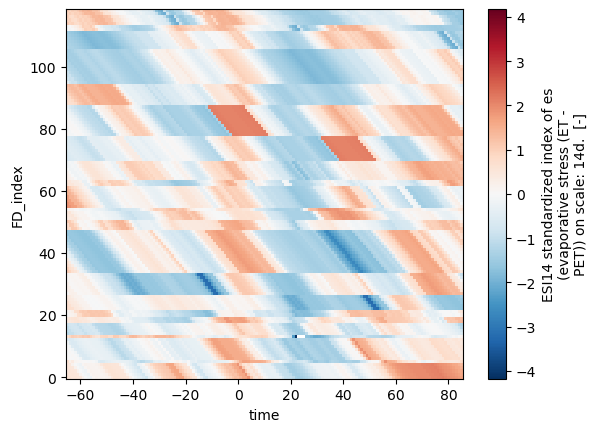

In [114]:
ds_comp['ESI14'].plot()

In [28]:

def define_ts_length(year,month,day,window,extra_len):

    # make the right type
    window = int(window)
    extra_len = int(extra_len)
    
    start_FD_time = datetime(year,month,day)

    # when do we want the composite timeseries to start and end:
    start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len))
    end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len))

    # however, if there is a leap day in this period, we need to add an extra day to the time series before or after  
    # first we check is the year prior is a leap year, and if the date is at the end of the year
    if check_leap_year(year+1): 
        leap_day = datetime(year+1,2,29)
        # is next years leap day between the start of the timeseries and the start of the event: add a day BEFORE
        print(start_ts_time)
        print(leap_day)
        print(start_FD_time)
        if start_ts_time <= leap_day <= start_FD_time:
            start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len+1))
        elif start_FD_time <= leap_day <= end_ts_time:
            end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))


    
    elif check_leap_year(year):
        leap_day = datetime(year,2,29)
        
        # is the leap day between the start of the timeseries and the start of the event: add a day BEFORE
        if start_ts_time <= leap_day <= start_FD_time:
            start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len+1))
        # is the leap day between the the start of the event and the end of the timeseries: add a day AFTER
        elif start_FD_time <= leap_day <= end_ts_time:
            end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))

    
    # TODO verbeter leap year voor kerst case 
    # diri_csv = '/perm/nklm/Px_flashdroughts/ERA5_FD_events/'
    # fili_csv = 'Rhine_SMI-7_w28_j20_e15.csv'
    # event 33 



    return start_ts_time, end_ts_time

In [31]:
year=2019
month=12
day=26
window=30
extra_len=60
start_ts_time, end_ts_time = define_ts_length(year,month,day,window,extra_len)

In [23]:
leap_day = datetime(year+1,2,29)

In [24]:
leap_day

datetime.datetime(2020, 2, 29, 0, 0)

In [26]:
end_ts_time

datetime.datetime(2020, 3, 25, 0, 0)

In [39]:
end_ts_time - start_ts_time

datetime.timedelta(days=151)

In [15]:
check_leap_year(year+1)

True

In [15]:
year=2019
month=12
day=1
window=30
extra_len=60




# make the right type
window = int(window)
extra_len = int(extra_len)

start_FD_time = datetime(year,month,day)
# when do we want the composite timeseries to start and end:
start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len))
end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len))
# however, if there is a leap day in this period, we need to add an extra day to the time series before or after  

# first we check if next year is a leap year, and if the date is at the end of the year
if check_leap_year(year+1): 
    leap_day = datetime(year+1,2,29)
    # is next years leap day between the start of the timeseries and the start of the event: add a day BEFORE
    print(start_ts_time)
    print(leap_day)
    print(start_FD_time)
    print(end_ts_time)
    if start_ts_time <= leap_day <= start_FD_time:
        start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len+1))
    elif start_FD_time <= leap_day <= end_ts_time:
        end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))

elif check_leap_year(year):
    leap_day = datetime(year,2,29)
    
    # is the leap day between the start of the timeseries and the start of the event: add a day BEFORE
    if start_ts_time <= leap_day <= start_FD_time:
        start_ts_time = datetime(year,month,day) + timedelta(days=-(extra_len+1))
    # is the leap day between the the start of the event and the end of the timeseries: add a day AFTER
    elif start_FD_time <= leap_day <= end_ts_time:
        end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))

2019-10-02 00:00:00
2020-02-29 00:00:00
2019-12-01 00:00:00
2020-02-29 00:00:00


In [16]:
end_ts_time - start_ts_time

datetime.timedelta(days=151)

In [37]:
start_FD_time  <= leap_day <= end_ts_time

True

In [38]:
end_ts_time = datetime(year,month,day) + timedelta(days=(window+extra_len+1))